In [200]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [201]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [202]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [203]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [204]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
10075,1697837400,1.05879,1.05961,1.05870,1.05920,1812,9,0
10076,1697839200,1.05921,1.05943,1.05891,1.05913,1496,9,0
10077,1697841000,1.05913,1.05927,1.05879,1.05918,1593,9,0
10078,1697842800,1.05918,1.05934,1.05913,1.05922,1089,9,0


In [205]:



def psar(df = None, af0=0.02, af=0.02, maxaf=0.2, offset=0):
    psar = ta.psar(high=df['high'], low=df['low'], close=df['close'], af0=af0, af=af,max_af=maxaf, offset=0)
    df[f'PSARl_{af}_{maxaf}'] = psar[f'PSARl_{af}_{maxaf}']
    df[f'PSARs_{af}_{maxaf}'] = psar[f'PSARs_{af}_{maxaf}']
    df[f'PSARaf_{af}_{maxaf}'] = psar[f'PSARaf_{af}_{maxaf}']
    df[f'PSARr_{af}_{maxaf}'] = psar[f'PSARr_{af}_{maxaf}']
    return df




In [206]:


af0=0.02
af=0.02
maxaf=0.2
offset=0

smalookback = 50

df = psar(df, af0, af, maxaf, offset)

df['sma'] = ta.sma(close=df['close'], length=smalookback)

df



,time,open,high,low,close,tick_volume,spread,real_volume,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,sma
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0,NaN,NaN,0.02,0,NaN
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0,1.068830,NaN,0.02,1,NaN
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0,NaN,1.06978,0.02,1,NaN
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0,1.068730,NaN,0.02,1,NaN
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0,1.068730,NaN,0.04,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,1697837400,1.05879,1.05961,1.05870,1.05920,1812,9,0,1.058264,NaN,0.08,0,1.058190
10076,1697839200,1.05921,1.05943,1.05891,1.05913,1496,9,0,1.058429,NaN,0.08,0,1.058181
10077,1697841000,1.05913,1.05927,1.05879,1.05918,1593,9,0,1.058580,NaN,0.08,0,1.058204
10078,1697842800,1.05918,1.05934,1.05913,1.05922,1089,9,0,1.058719,NaN,0.08,0,1.058215


In [207]:
buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 2.0 / 100

slamount = None
tpamount = None

for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['close'] > df.iloc[i]['sma']) and (df.iloc[i - 1]['close'] < df.iloc[i]['sma']) and (df.iloc[i][f'PSARl_{af}_{maxaf}'] > 0):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        (
            # Try commenting this stop loss to allow the code to wait for getting the take profit condition
            df.iloc[i]['close'] <= slamount
        ) or (
            df.iloc[i]['close'] >= tpamount
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None



In [208]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.06779, 1.06192, 1.05421, 1.07443, 1.09295, 1.07598, 1.07245, 1.06881, 1.06635, 1.06065, 1.0555, 1.0778, 1.09486, 1.08714, 1.08463, 1.07898, 1.07318, 1.07153, 1.06887, 1.0925799999999999, 1.09062, 1.08706, 1.1232199999999999, 1.11297, 1.10831, 1.10526, 1.10172, 1.09822, 1.09377, 1.0919699999999999, 1.08893, 1.08493, 1.08088, 1.07305, 1.06663, 1.06001, 1.05892, 1.04744]
[1.06233, 1.05519, 1.0758, 1.09773, 1.08391, 1.07013, 1.06682, 1.06323, 1.06094, 1.05534, 1.07785, 1.09958, 1.08902, 1.08149, 1.07895, 1.07338, 1.0677, 1.06592, 1.09176, 1.0868, 1.08433, 1.10975, 1.11484, 1.10706, 1.1026799999999999, 1.09929, 1.09569, 1.09194, 1.08811, 1.08626, 1.08173, 1.07941, 1.07418, 1.06765, 1.06102, 1.05378, 1.05357]
[60, 164, 223, 320, 1175, 1287, 1293, 1458, 1666, 1877, 1942, 2758, 3667, 4580, 4712, 4770, 5001, 5112, 5186, 5825, 6003, 6222, 6737, 6966, 7026, 7070, 7180, 7293, 7375, 7746, 7879, 8050, 8142, 8553, 8854, 9192, 9379, 9451]
[67, 175, 277, 1099, 1183, 1289, 1429, 1648, 1818, 1903, 271

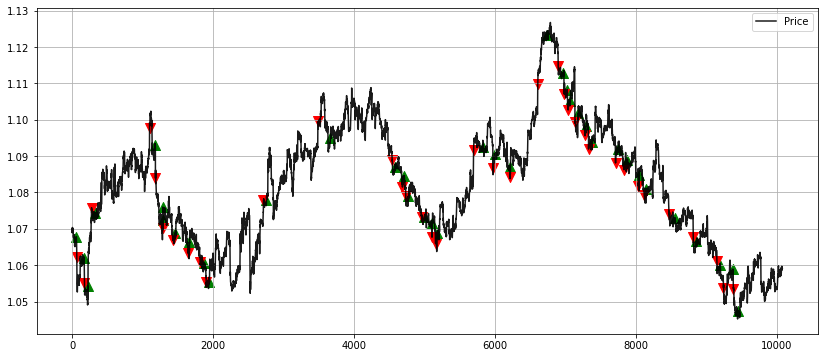

In [209]:

plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()



In [210]:




brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

if profit and wins:
    averageprofit = profit / wins

if loss and losses:
    averageloss = loss / losses

hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 16.216216216216218 %
    Profit factor = 0.1322237750618719 {currency}
    Expectancy = 0.443113724760244 {currency}
    Realised risk reward ratio = 0.683156171153005 {currency}

